# Predicting most Efficient Interventions for Life Span Increase
#### Data Literacy at University of Tübingen, Winter 2023/24

---
&copy; Daniel Flat, Jackson Harmon, Eric Nazarenus, Aline Bittler 2023. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

Template by Philipp Hennig, 2023. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

In [1]:
import os
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dataclasses import dataclass
from scipy.optimize import curve_fit

from sklearn.model_selection import train_test_split

In [2]:
# Group Constants
MALE = 'male'
FEMALE = 'female'
SEX_CATEGORIES = [MALE, FEMALE]

# Dataset
CATEGORY_COLUMN = 'category'
SEX_COLUMN = 'sex'
VALIDATION_PERCENTAGE = 0.2

# Intervention Constants
N_SINGLE_INTERVENTIONS = 4

CONTROL_GROUP = 'None'
ALL_GROUP = 'All'
ONE_REMOVED_PREFIX = 'no_'

# Dataset Contsants
DATASET_DIRECTORY = os.path.join('..', 'dat', 'final_datasets', 'female_final.csv')

# Graphing constants
COLOR_MAP = ["#ADD8E6", "#008000", "#FFD700", "#800080", "#FF7F50", "#40E0D0", "#708090", "#FF8C00", "#FF00FF", "#008080"]

# Numerical Constants
EPS = 1e-7

### Parsing the data
In this section we take the extracted values of the robust mouse rejuvination study and wrangle the data into the format needed for modeling the data.

In [3]:
def is_one_removed_intervention(key):
    if len(key) < 3:
        return False

    return key[:len(ONE_REMOVED_PREFIX)] == ONE_REMOVED_PREFIX

def convert_one_removed_intervention_key_to_canonical_key(key: str, intervention_list: []) -> []:
    removed_key = key[len(ONE_REMOVED_PREFIX):]

    removed_intervention_list = []
    for intervention in intervention_list:
        if intervention != removed_key:
            removed_intervention_list.append(intervention)

    return removed_intervention_list

def create_canonical_intervention_key(key: str, intervention_list: []):
    canonical_interventions = None
    
    if key == ALL_GROUP:
        canonical_interventions = intervention_list
    elif key == CONTROL_GROUP:
        canonical_interventions = []
    elif is_one_removed_intervention(key):
        canonical_interventions = convert_one_removed_intervention_key_to_canonical_key(key, intervention_list)
    else:
        canonical_interventions = [key]

    return ','.join(canonical_interventions)

In [4]:
def load_csv(path):
    return pd.read_csv(
                        path,
                        skiprows=0,
                        sep=',',
                        engine='python',
                        decimal='.',
                        dtype={'x': 'float64', 'y': 'float64'}
            )

def extract_one_intervention_keys(dataset):
    categories = dataset[CATEGORY_COLUMN].unique()

    single_interventions = []
    for category in categories:
        if category == ALL_GROUP:
            continue
        elif category == CONTROL_GROUP:
            continue
        elif is_one_removed_intervention(category):
            continue
        else:
            single_interventions.append(category)
    
    return single_interventions

def create_two_intervention_keys(one_interventions):
    two_interventions = []
    for i in range(len(one_interventions)):
        for j in range(i + 1, len(one_interventions)):
            intervention_pair = ','.join([one_interventions[i], one_interventions[j]])
            two_interventions.append(intervention_pair)
    return two_interventions

def extract_three_intervention_keys(dataset):
    return [intervention for intervention in dataset.keys() if intervention.count(',') == 2]    

def extract_four_intervention_keys(dataset):
    for intervention in dataset.keys():
        if intervention.count(',') == 3:
            return intervention
    raise ValueError('No four intervention data found')

def create_dataset_mapping(dataset, single_interventions: []):
    dataset_by_category = {}
    for intervention in dataset[CATEGORY_COLUMN].unique():
        key = create_canonical_intervention_key(intervention, single_interventions)
        intervention_indices = dataset[CATEGORY_COLUMN] == intervention
        
        dataset_category = dataset[intervention_indices].copy()
        dataset_category = dataset_category.drop([SEX_COLUMN, CATEGORY_COLUMN], axis=1)

        dataset_by_category[key] = dataset_category
    return dataset_by_category

def load_and_preprocess(dataset_path):
    dataset = load_csv(dataset_path)
    
    # fixes naming of no Gal-Nav in dataset for preprocessing
    misnamed_no_gal_nav_index = dataset[CATEGORY_COLUMN] == 'no_Gal_Nav'
    dataset.loc[misnamed_no_gal_nav_index, CATEGORY_COLUMN] = 'no_Gal-Nav'

    # fixes naming of no interventions
    misnamed_no_intervention_index = dataset[CATEGORY_COLUMN].isna()
    dataset.loc[misnamed_no_intervention_index, CATEGORY_COLUMN] = CONTROL_GROUP
    
    # remove nan rows, if applicable
    return dataset.dropna()

raw_dataset = load_and_preprocess(DATASET_DIRECTORY)
raw_train, raw_validation = train_test_split(raw_dataset, test_size=VALIDATION_PERCENTAGE)

one_interventions = extract_one_intervention_keys(raw_train)
two_interventions = create_two_intervention_keys(one_interventions)

female_dataset = create_dataset_mapping(raw_train, one_interventions)

three_interventions = extract_three_intervention_keys(female_dataset)
all_interventions_key = extract_four_intervention_keys(female_dataset)

### Modeling
It should be noted that from the study we have data on the following:
- No interventions
- Single Interventions
- Three Interventions
- Four (All) Interventions

Because of this we can simply fit the Gompertz curve to each of these for those resp. models. However in order to fufill the objective of finding the combination of interventions most likely to increase the lifespan of mice we still need to consider one case, that is, the case of two interventions. In order to do this in the following sections we come of with models with how interventions relate to one-another and then test how these assumptions hold on the data we have. For example, we might make an assumption on how the interventions interact with each other using only single and three intervention data. We can then validate this assumption by measuring how it performs on the all interventions. If it holds well, then we apply the same assumption to the two interventions.

After modeling the two interventions, and with regard to the assumptions, we can use the model of each case and simply take the best performing curve as our prediction of the best subset of interventions.

In [5]:
def gompertz(x, alpha, beta):
    return alpha * np.exp(beta * x)

@dataclass
class GompertzParameters:
    alpha: np.float64
    beta: np.float64

    @staticmethod
    def from_sequence(seq):
        return GompertzParameters(alpha=seq[0], beta=seq[1])

    def to_tuple(self):
        return (self.alpha, self.beta)

    def __str__(self) -> str:
        return f'(alpha={self.alpha:.4f}, beta={self.beta:.4f})'

    def __repr__(self) -> str:
        return f'(alpha={self.alpha:.4f}, beta={self.beta:.4f})'


DEFAULT_INITIAL_PARAMETERS = GompertzParameters(alpha=0.1, beta=0.085)

def fit_gompertz_model(ages: pd.DataFrame,
                       mortality_rate: pd.DataFrame,
                       initial_parameters: GompertzParameters = DEFAULT_INITIAL_PARAMETERS,
                       max_fit_iterations: int = 2_500) -> GompertzParameters:
    p0 = initial_parameters.to_tuple()
    predicted_parameters, covariance = curve_fit(gompertz, ages, mortality_rate, p0=p0, maxfev=max_fit_iterations)
    return GompertzParameters.from_sequence(predicted_parameters)

def calculate_ages(dataset):
    return np.array(dataset.x) / 365 # ages in years

def calculate_mortality_rate(dataset):
    return np.array(1 - dataset.y)

### Helper Methods / Classes

In [6]:
class InterventionSlopes:
    def __init__(self):
        self.slopes = {}

    def add_intervention_slope(self, key, ages, log_mortality):
        self.slopes[key] = self._calculate_slope(ages, log_mortality)

    def _calculate_slope(self, ages, log_mortality):
        numerator = log_mortality[-1] - log_mortality[0]
        denominator = ages[-1] - log_mortality[0]
        slope = numerator / denominator
        return slope

    def calculate_best_intervention(self):
        best_intervention = None
        best_slope = None
        
        for intervention, slope in self.slopes.items():
            if best_slope is None or best_slope > slope:
                best_intervention = intervention
                best_slope = slope
        
        return best_intervention
    
    def plot_inverse_slopes(self):
        fig = plt.figure(figsize=(15, 3))

        inverse_sorted_slopes = self._calculate_inverse_sorted_slopes()
        for key, slope in inverse_sorted_slopes.items():
            plt.bar(key, slope)

        plt.xticks(rotation=-90)
        plt.ylabel(f'1 / Slope')
        plt.title('Ranked Interventions (Best to worst)')
        plt.show()

    def _calculate_inverse_sorted_slopes(self):
        inverse_slopes = {key: 1 / slope for key, slope in self.slopes.items()}
        inverse_sorted_slopes = dict(sorted(inverse_slopes.items(), key=lambda item: item[1], reverse=True))
        return inverse_sorted_slopes

slopes = InterventionSlopes()

In [33]:
class Plotter:
    def __init__(self, dataset, ages, log_mortality, keys, plot_type):
        self.dataset = dataset
        self.ages = ages
        self.log_mortality = log_mortality
        self.keys = keys
        self.plot_type = plot_type

    def plot(self):
        self.plot_type.plot(self.dataset, self.ages, self.log_mortality, self.keys)

class NoInterventionPlotter:
    def plot(self, dataset, ages, log_mortality, key):
        ages = calculate_ages(dataset[key])

        no_intervention_mortality_rate = calculate_mortality_rate(dataset[key])
        no_intervention_log_mortality_rate = np.log(no_intervention_mortality_rate + EPS)

        plt.scatter(ages, no_intervention_log_mortality_rate, label='Observed Data', color=COLOR_MAP[0])
        plt.plot(ages, log_mortality, label='Fit', color=COLOR_MAP[1])
        plt.xlabel('Age of Mice (Years)')
        plt.ylabel(f'Mortality Rate (Control Group)')
        plt.legend()
        plt.show()

class TwoInterventionPlotter:
    FIG_SIZE = (15, 10)
    N_INTERVENTIONS = 4

    def plot(self, dataset, ages, log_mortality, keys):
        fig = plt.figure(figsize=(15, 5))

        interaction_factor_index = 0
        for i in range(self.N_INTERVENTIONS):
            for j in range(i + 1, self.N_INTERVENTIONS):
                log_mortality_rate = log_mortality[interaction_factor_index]

                title = self._create_intervention_title(keys, i, j)
                color = COLOR_MAP[interaction_factor_index]

                plt.plot(ages, log_mortality_rate, label=title, color=color)
                interaction_factor_index += 1
    
        plt.title('Two Intervention Mortality Rate')
        plt.xlabel('Age of Mice (Years)')
        plt.ylabel(f'Log Mortality Rate')
        plt.legend()
        plt.show()

    def _create_intervention_title(self, keys, i, j):
        return f'{keys[i]},{keys[j]}'


class ThreeInterventionPlotter:
    N_COLS = 2
    N_ROWS = 2
    FIG_SIZE = (15, 10)

    def plot(self, dataset, ages, log_mortality, keys):
        fig, axis = plt.subplots(self.N_COLS, self.N_ROWS, figsize=self.FIG_SIZE)
        
        for i in range(len(log_mortality) // self.N_COLS):
            for j in range(self.N_COLS):
                intervention_index = self.N_COLS * i + j
        
                # Get the acutal data points
                intervention_key = keys[intervention_index]
                intervention_dataset = dataset[intervention_key]
    
                current_ages = calculate_ages(intervention_dataset)
                actual_log_mortality_rate = np.log(calculate_mortality_rate(intervention_dataset) + EPS)
        
                # Use predicted mortality rate
                log_mortality_rate = log_mortality[intervention_key]
        
                # Plot
                axis[i][j].scatter(current_ages, actual_log_mortality_rate, label='Observed Data', color=COLOR_MAP[0])
                axis[i][j].plot(ages, log_mortality_rate, label='All Gompertz Fit', color=COLOR_MAP[1])
                    
                axis[i][j].set_xlabel('Age of Mice (Years)')
                axis[i][j].set_ylabel(f'Mortality Rate ({intervention_key})')
        
        plt.tight_layout()
        plt.show()


class AllInterventionPlotter:
    def plot(self, dataset, ages, log_mortality, key):
        # plt.scatter(all_interventions_ages, log_mortality_rate, label='Observed Data', color=COLOR_MAP[0])
        plt.plot(ages, log_mortality, label='All Gompertz Fit', color=COLOR_MAP[1])
        plt.xlabel('Age of Mice (Years)')
        plt.ylabel(f'Mortality Rate')
        plt.legend()
        plt.show()

We keep track of the predicted slopes of the log mortality rate and use this a measure of the effectiveness of the intervention. That is, the smaller of the slope, the more better the intervention.

### Second-Order Model
Notation: m_i, m_ij and m_ijk are the predicted mortality rate when using interventions i; i and j; and i, j, and k resp. i_jk and i_jkl are the interaction factors of how "non-linear" the mortality rate is. That is,
i_jk = m_jk - (m_j + m_k)
i_jkl = m_jkl - (m_j + m_k + m_l)

Therefore we can come up with the following equations (1):

m_123 = m_1 + m_2 + m_3 + i_123

m_124 = m_1 + m_2 + m_4 + i_124

m_234 = m_2 + m_3 + m_4 + i_234

m_1234 = m_1 + m_2 + m_3 + m_4 + i_1234

We can make further assumptions that interactions are pairwise additive. That is,
i_123 = i_12 + i_13 + i_23

This leads us to the following equations (2):

i_123 = i_12 + i_13 + i_23

i_124 = i_12 + i_14 + i_24

i_234 = i_23 + i_24 + i_34

i_1234 = i_12 + i_13 + i_14 + i_23 + i_24 + i_34

We already know the values of the m's, but just not the i's. While equations (1) are 4 equations of 4 unknowns, meaning we can solve for the i's, unfortunately equations (2) is 4 equations of 6 unknowns therefore has multiple solutions. We use the pseudo inverse to solve it for one particular solution.

In [34]:
def compute_alpha_and_beta(dataset):
    alpha_parameters = {}
    beta_parameters = {}
    
    for key, current_dataset in female_dataset.items():
        all_ages = calculate_ages(current_dataset)
        all_mortality_rate = calculate_mortality_rate(current_dataset)
        
        predicted_parameters = fit_gompertz_model(all_ages, all_mortality_rate)
        
        alpha_parameters[key] = predicted_parameters.alpha
        beta_parameters[key] = predicted_parameters.beta
    
    return alpha_parameters, beta_parameters

def compute_mortality_by_n_interventions(ages, alpha_parameters, beta_parameters, intervention_keys):
    mortality = []
    for key in intervention_keys:
        mortality_rate = calculate_mortality_rate(female_dataset[key])
        
        alpha = alpha_parameters[key]
        beta = beta_parameters[key]
        
        mortality.append(gompertz(ages, alpha, beta))
    
    return mortality

alpha_parameters, beta_parameters = compute_alpha_and_beta(female_dataset)

all_interventions_ages = calculate_ages(female_dataset[all_interventions_key])
all_interventions_mortality_rate = calculate_mortality_rate(female_dataset[all_interventions_key])

one_interventions_mortality = compute_mortality_by_n_interventions(all_interventions_ages, alpha_parameters, beta_parameters, one_interventions)
three_interventions_mortality = compute_mortality_by_n_interventions(all_interventions_ages, alpha_parameters, beta_parameters, three_interventions)

In [35]:
def compute_non_linearity_difference(one_intervention_mortality, three_interventions_mortality):
    three_intervention_indices = list(combinations(range(4), 3))

    diffs = []
    for i in range(len(three_intervention_indices)):
        diff = three_interventions_mortality[i].copy()
        for index in three_intervention_indices[i]:
            diff -= np.array(one_intervention_mortality[index])
        diffs.append(diff)

    return diffs


diffs = compute_non_linearity_difference(one_interventions_mortality, three_interventions_mortality)

In [36]:
# Here we have the linear model
# the (i, j) entry being one in a row
# represents the (i, j) factor
# being included.
#
# e.g. the first row has factors
# i_12 + i_13 + i_23
#
# the columns represent factors:
# (1,2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)
linear_model = np.array([
            [1, 1, 0, 1, 0, 0],
            [1, 0, 1, 0, 1, 0],
            [0, 1, 1, 0, 0, 1],
            [0, 0, 0, 1, 1, 1],
])

inverse_linear_model = np.linalg.pinv(linear_model)

interaction_factors = []
for time_step in range(len(diffs[0])):
    current_time_step_diff = np.array(list([diff[time_step] for diff in diffs]))
    time_step_interaction_factors = inverse_linear_model @ current_time_step_diff
    interaction_factors.append(time_step_interaction_factors)

### Predict No Interventions

In [37]:
NO_INTERVENTION_KEY = ''

# Compute prediction
no_intervention_ages = calculate_ages(female_dataset[NO_INTERVENTION_KEY])
no_intervention_mortality_rate = calculate_mortality_rate(female_dataset[NO_INTERVENTION_KEY])
no_intervention_log_mortality_rate = np.log(no_intervention_mortality_rate + EPS)

predicted_parameters = fit_gompertz_model(no_intervention_ages, no_intervention_mortality_rate)
predicted_mortality = gompertz(no_intervention_ages, predicted_parameters.alpha, predicted_parameters.beta)
log_predicted_mortality = np.log(predicted_mortality + EPS)

slopes.add_intervention_slope('No Interventions', no_intervention_ages, log_predicted_mortality)

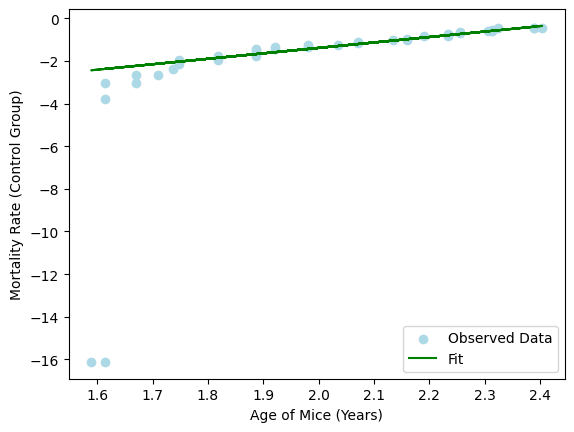

In [38]:
plot_type = NoInterventionPlotter()
plotter = Plotter(female_dataset, no_intervention_ages, log_predicted_mortality, NO_INTERVENTION_KEY, plot_type)
plotter.plot()

#### Predict Single Interventions

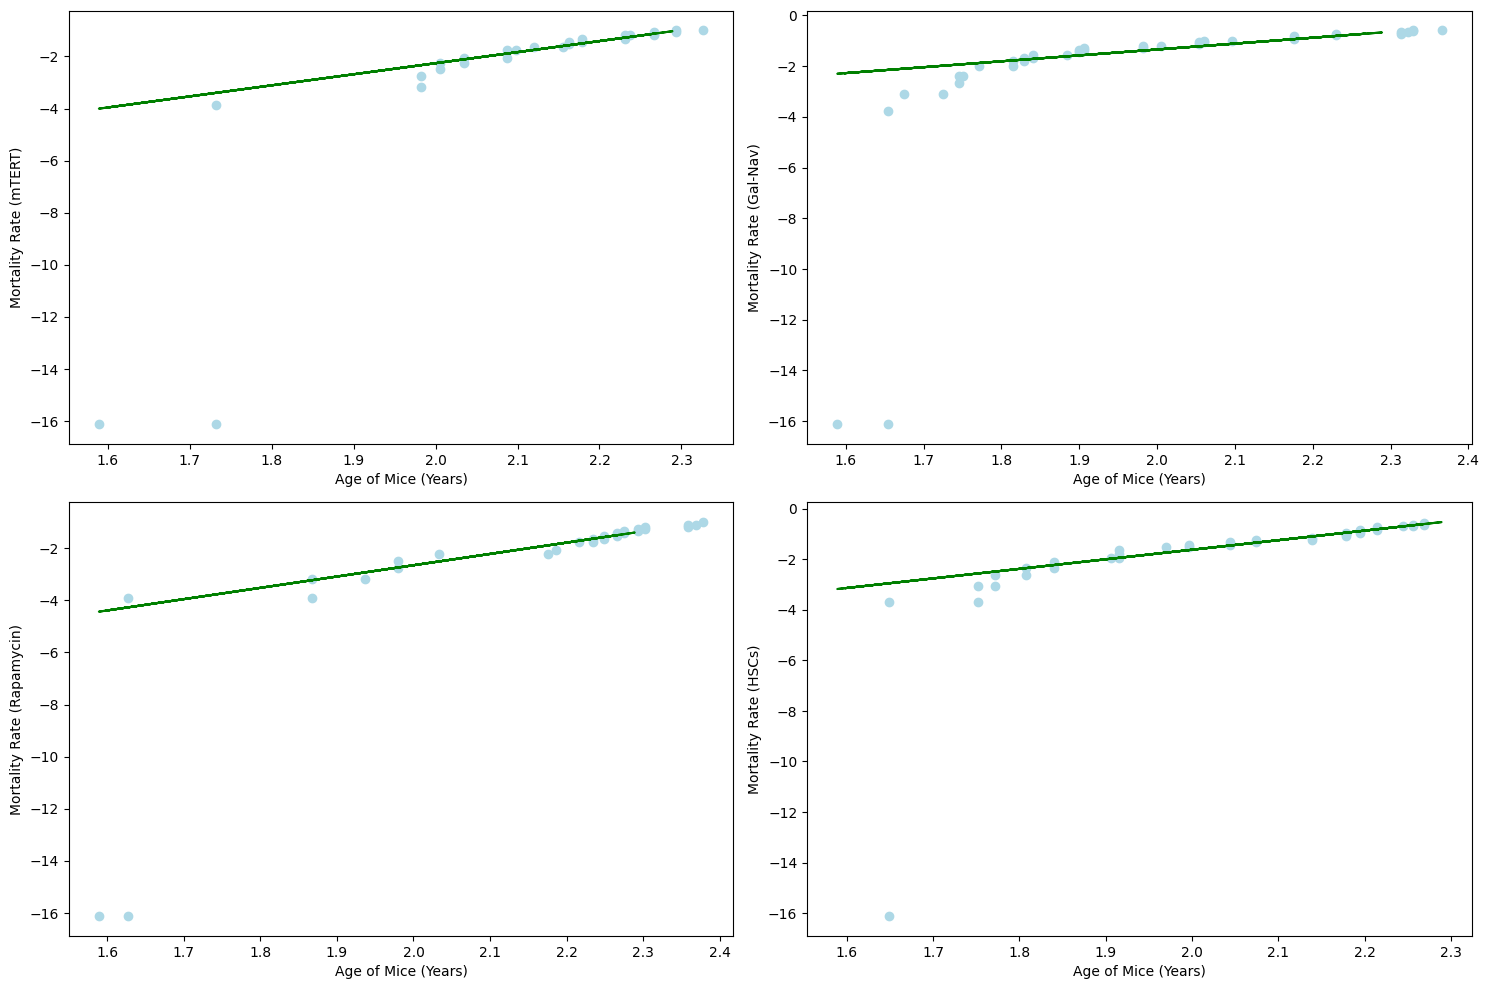

In [25]:
##############
##############
# WIP
##############
##############

class TwoInterventionPlotter:
    N_COLUMNS = 2
    N_ROWS = 2

    def plot(self, dataset, ages, log_mortality, keys):
        fig, axis = plt.subplots(n_cols, n_rows, figsize=(15, 10))
        
        for i in range(len(one_interventions_mortality) // n_cols):
            for j in range(n_cols):
                intervention_index = n_cols * i + j
        
                # Get the acutal data points
                intervention_key = one_interventions[intervention_index]
                current_dataset = female_dataset[intervention_key]
                
         
                current_ages = calculate_ages(current_dataset)
                actual_log_mortality_rate = np.log(calculate_mortality_rate(current_dataset) + EPS)
        
                # Use predicted mortality rate
                single_log_mortality_rate = np.log(one_interventions_mortality[intervention_index] + EPS)
        
                # Compute slopes
                slopes.add_intervention_slope(intervention_key, current_ages, single_log_mortality_rate)
        
                # Plot
                axis[i][j].scatter(current_ages, actual_log_mortality_rate, label='Observed Data', color=COLOR_MAP[0])
                axis[i][j].plot(all_interventions_ages, single_log_mortality_rate, label='All Gompertz Fit', color=COLOR_MAP[1])
                    
                axis[i][j].set_xlabel('Age of Mice (Years)')
                axis[i][j].set_ylabel(f'Mortality Rate ({intervention_key})')
        
        plt.tight_layout()
        plt.show()

    def _create_intervention_title(self, keys, i, j):
        return f'{keys[i]},{keys[j]}'

n_cols = 2
n_rows = 2
fig, axis = plt.subplots(n_cols, n_rows, figsize=(15, 10))

for i in range(len(one_interventions_mortality) // n_cols):
    for j in range(n_cols):
        intervention_index = n_cols * i + j

        # Get the acutal data points
        intervention_key = one_interventions[intervention_index]
        current_dataset = female_dataset[intervention_key]
        
 
        current_ages = calculate_ages(current_dataset)
        actual_log_mortality_rate = np.log(calculate_mortality_rate(current_dataset) + EPS)

        # Use predicted mortality rate
        single_log_mortality_rate = np.log(one_interventions_mortality[intervention_index] + EPS)

        # Compute slopes
        slopes.add_intervention_slope(intervention_key, current_ages, single_log_mortality_rate)

        # Plot
        axis[i][j].scatter(current_ages, actual_log_mortality_rate, label='Observed Data', color=COLOR_MAP[0])
        axis[i][j].plot(all_interventions_ages, single_log_mortality_rate, label='All Gompertz Fit', color=COLOR_MAP[1])
            
        axis[i][j].set_xlabel('Age of Mice (Years)')
        axis[i][j].set_ylabel(f'Mortality Rate ({intervention_key})')

plt.tight_layout()
plt.show()

### Predict Two Interventions

In [26]:
def calculate_two_intervention_log_mortality_rates(interaction_factors, n_interventions):
    log_mortality_rates = []

    interaction_factor_index = 0
    for i in range(n_interventions):
        for j in range(i + 1, n_interventions):
            interaction_factor = np.array([factor[interaction_factor_index] for factor in interaction_factors])
            
            two_intervention_mortality_rate = one_interventions_mortality[i] + one_interventions_mortality[j] + interaction_factor
            log_mortality_rate = np.log(two_intervention_mortality_rate + 1e-7)

            log_mortality_rates.append(log_mortality_rate)
            
            interaction_factor_index += 1
    
    return log_mortality_rates


two_interventions_log_mortality = calculate_two_intervention_log_mortality_rates(interaction_factors, N_SINGLE_INTERVENTIONS)

In [27]:
interaction_factor_index = 0
for i in range(N_SINGLE_INTERVENTIONS):
    for j in range(i + 1, N_SINGLE_INTERVENTIONS):
        log_mortality_rate = two_interventions_log_mortality[interaction_factor_index]

        intervention_key = two_interventions[interaction_factor_index]
        slopes.add_intervention_slope(intervention_key, all_interventions_ages, log_mortality_rate)

        interaction_factor_index += 1

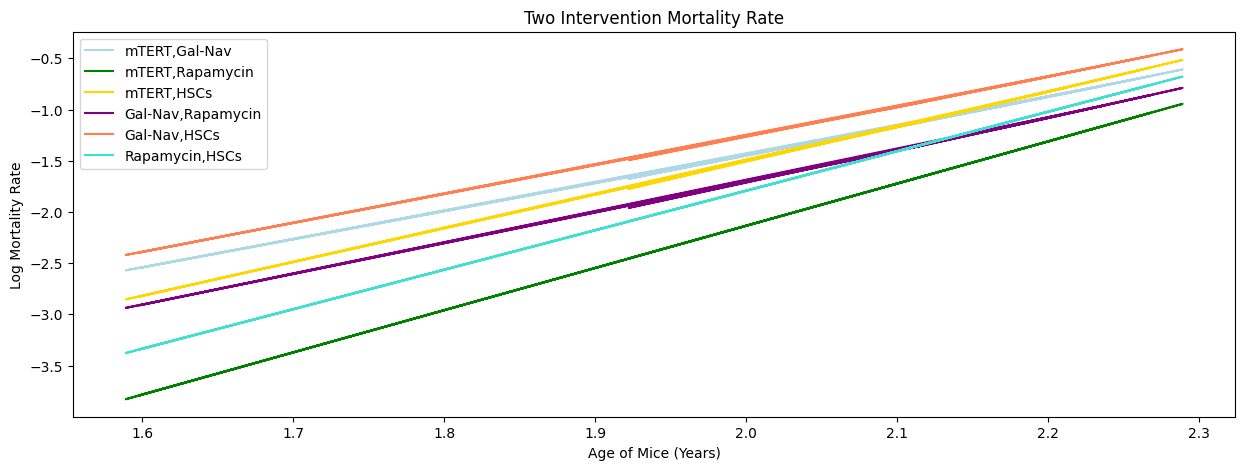

In [28]:
plot_type = TwoInterventionPlotter()
plotter = Plotter(female_dataset, all_interventions_ages, two_interventions_log_mortality, one_interventions, plot_type)
plotter.plot()

### Predict Three Interventions

In [29]:
interaction_factor_index = 0
n_interventions = 4

three_intervention_indices = np.array([
            [0, 1, 3],
            [0, 2, 4],
            [1, 2, 5],
            [3, 4, 5]
])

def compute_three_interventions_interactions(three_intervention_indices, interaction_factors):
    interaction_factors = np.array(interaction_factors)

    interactions = []
    for indices in three_intervention_indices:
        interaction = sum([interaction_factors[:, index] for index in indices])
        interactions.append(interaction)

    return np.array(interactions)

def compute_three_intervention_single(one_interventions_mortality):
    intervention_matrix = np.array(one_interventions_mortality)

    three_intervention_indices = list(combinations(range(4), 3))

    single_interventions = []
    for indices in three_intervention_indices:
        intervention_sum = 0
        for index in indices:
            intervention_sum += intervention_matrix[index]
        
        single_interventions.append(intervention_sum)

    return np.array(single_interventions)

def compute_log_mortality_rate(dataset, mortality_rate, keys):
    log_mortality_rates = {}
    for intervention_index in range(len(mortality_rate)):
        intervention_key = keys[intervention_index]
        log_mortality_rate = np.log(mortality_rate[intervention_index] + EPS)

        log_mortality_rates[intervention_key] = log_mortality_rate

    return log_mortality_rates

def add_three_intervention_slopes(slopes, log_mortality, ages, keys):
    for intervention_index in range(len(log_mortality)):
        intervention_key = keys[intervention_index]
        slopes.add_intervention_slope(intervention_key, ages, log_mortality[intervention_key])

interactions = compute_three_interventions_interactions(three_intervention_indices, interaction_factors)
interventions = compute_three_intervention_single(one_interventions_mortality)
three_interventions_mortality = interactions + interventions
three_interventions_log_mortality = compute_log_mortality_rate(female_dataset, three_interventions_mortality, three_interventions)

add_three_intervention_slopes(slopes, three_interventions_log_mortality, all_interventions_ages, three_interventions)

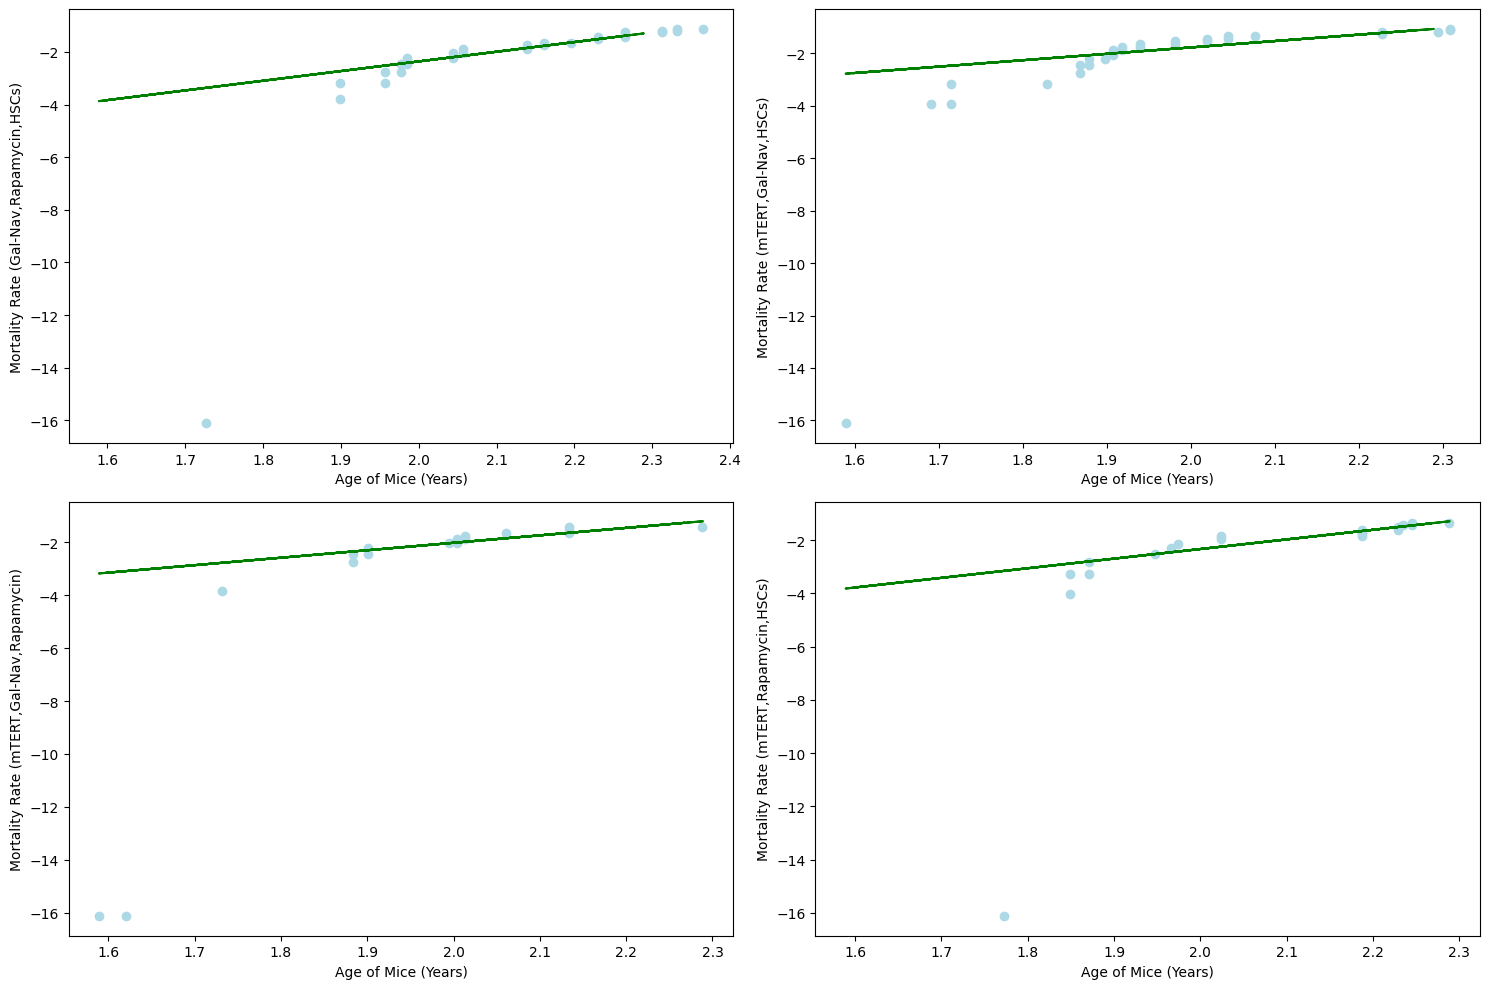

In [30]:
plot_type = ThreeInterventionPlotter()
plotter = Plotter(female_dataset, all_interventions_ages, three_interventions_log_mortality, three_interventions, plot_type)
plotter.plot()

### Predict All Interventions

In [ ]:
interventions = np.array(one_interventions_mortality).sum(axis=0)
interactions = np.array(interaction_factors).sum(axis=1)
all_interventions_mortality = interactions + interventions

all_log_interventions_mortality = np.log(all_interventions_mortality + EPS)

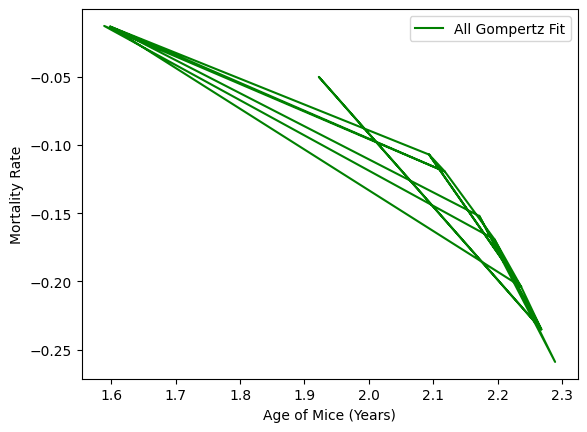

In [41]:
plot_type = AllInterventionPlotter()
plotter = Plotter(female_dataset, all_interventions_ages, all_interventions_mortality, '', plot_type)
plotter.plot()

### Evaluation

/tmp/ipykernel_15723/36371142.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  inverse_slopes = {key: 1 / slope for key, slope in self.slopes.items()}


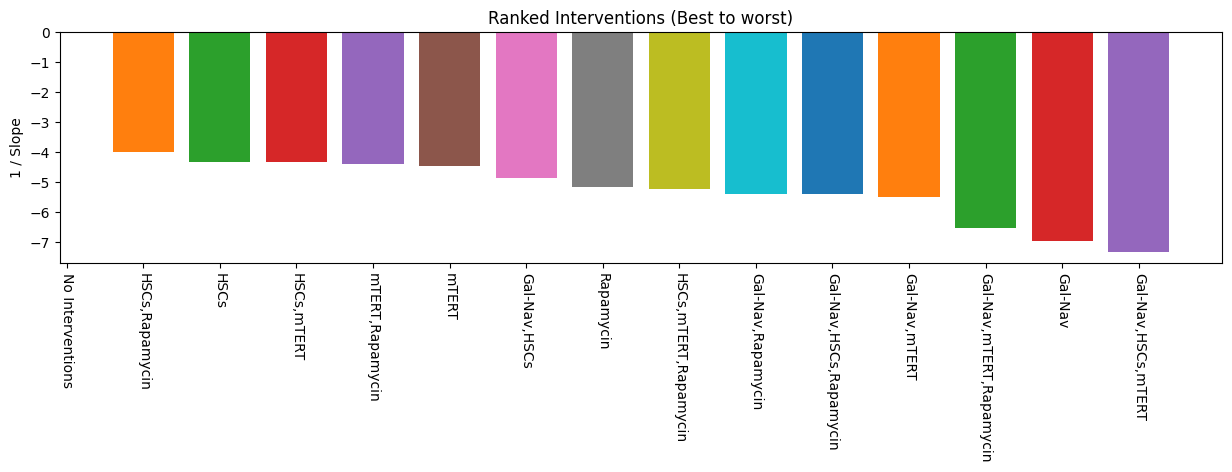

In [27]:
slopes.plot_inverse_slopes()

In the above graph, the inverse of the slope is shown for each intervention. We do this because this transform of the meaning (the inverse) means the larger the bar in the graph, the better the intervention

In [51]:
best_intervention = slopes.calculate_best_intervention()
print(f'The intervention with the best predicted increase in lifespan is "{best_intervention}".')

The intervention with the best predicted increase in lifespan is "No Interventions".
